# Анализ оттока клиентов фитнес-клуба

Цели проекта:
- прогноз вероятности оттока для каждого проекта;
- формирование типичных портретов пользователей;
- анализ признаков, влияющих на отток;
- рекомендации по повышению качества работы с клиентами.

[1. Предобработка данных](#1)

[2. Исследовательский анализ данных](#2)

[3. Модель прогнозирования оттока пользователей](#3)

[4. Кластеризация пользователей](#4)

[5. Выводы](#5)

In [34]:
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# кластеризация
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score

##  1. Предобработка данных <a name="1"></a>

In [36]:
# загрузка данных
df = pd.read_csv('/datasets/gym_churn.csv')
df.columns = df.columns.str.lower()
df.head(3).T

,0,1,2
gender,1.000000,0.000000,0.000000
near_location,1.000000,1.000000,1.000000
partner,1.000000,0.000000,1.000000
promo_friends,1.000000,0.000000,0.000000
phone,0.000000,1.000000,1.000000
contract_period,6.000000,12.000000,1.000000
group_visits,1.000000,1.000000,0.000000
age,29.000000,31.000000,28.000000
avg_additional_charges_total,14.227470,113.202938,129.448479
month_to_end_contract,5.000000,12.000000,1.000000


In [37]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null int64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


In [39]:
df.duplicated().sum()

0

Дубликатов и пропусков в данных нет, все типы данных соответствуют ожидаемым (кроме месяца до окончания контракта).

Все столбцы можно поделить на две категории - с двумя возможными значениями (качественный признак) и количественными значениями. Создадим их списки и посмотрим на распределение данных: для качественного признака достаточно посчитать среднее, для количественных - посмотреть на распределение.

In [40]:
# создание списков столбцов с различными типами признаков
binary_c = []
number_c = []
for col in df.columns: 
    if df[col].nunique() > 2:
        number_c.append(col)
    else:
        binary_c.append(col)

In [41]:
# средние значения для качественных признаков
df[binary_c].mean()

gender           0.51025
near_location    0.84525
partner          0.48675
promo_friends    0.30850
phone            0.90350
group_visits     0.41225
churn            0.26525
dtype: float64

По этим данным можно сделать выводы:
- примерно поровну мужчин и женщин;
- большинство (84,5%) живет или работает возле клуба;
- почти половина имеет скижки на абонемент (сотрудники компании-партнера);
- контактный номер телефона есть почти у всех (90,3%);
- 40% клиентов посещает групповые занятия;
- отток составляет 26,5%.

In [42]:
# распределение для количественных признаков
df[number_c].describe().T

,count,mean,std,min,25%,50%,75%,max
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


In [43]:
# отдельно посмотрим на доли клиентов с разными абонементами
df['contract_period'].value_counts(normalize = True)

1     0.55175
12    0.24000
6     0.20825
Name: contract_period, dtype: float64

Больше половины берет абонемент всего на месяц; 24% - на год, 20% - на полгода.
Средний возраст - 29 лет (что странно, потому что 41 - максимальный). Среднее время от покупки абонемента - 3 месяца. Средняя частота посещений в неделю - меньше двух.

Отклонений в данных нет, можно переходить к анализу.

##  2. Исследовательский анализ данных <a name="2"></a>

Посмотрим на разницу между ушедшими и оставшимися клиентами.

In [44]:
difference = df.groupby('churn').mean().T
# процентное соотношение для показателей
difference['percent'] = (difference[0] / difference[1] - 1) * 100
difference.sort_values(by = 'percent')

churn,0,1,percent
gender,0.510037,0.510839,-0.156880
phone,0.903709,0.902922,0.087158
age,29.976523,26.989632,11.066806
near_location,0.873086,0.768143,13.661882
avg_class_frequency_total,2.024876,1.474995,37.280201
avg_additional_charges_total,158.445715,115.082899,37.679635
partner,0.534195,0.355325,50.339846
group_visits,0.464103,0.268615,72.776753
promo_friends,0.353522,0.183789,92.352012
avg_class_frequency_current_month,2.027882,1.044546,94.140088


Разница несущественна только для двух признаков - пол и наличие телефона. Все остальные признаки различаются, причем довольно существенно, и больше всего - признаки, относящиеся к длительности контракта.

Для качественных признаков построим столбчатые графики, пересчитанные в доли, чтобы можно было сравнивать не абсолютные значения, а относительные - ведь ушедших клиентов гораздо меньше.

Для количественных построим гистограммы и распределения.

In [45]:
binary_c.remove('churn')

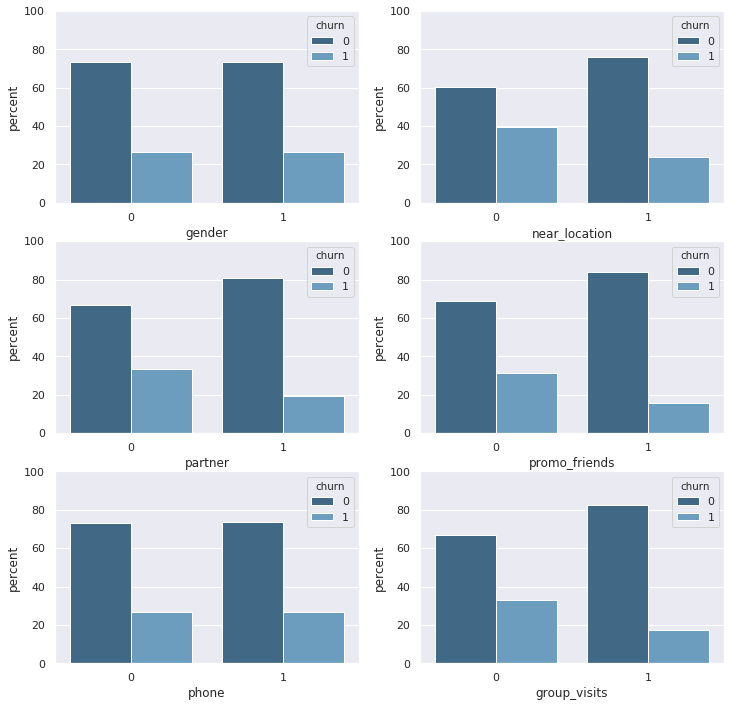

In [46]:

f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, binary_c):
    percent = (df.groupby(col)['churn']
                     .value_counts(normalize=True).mul(100)
                     .rename('percent').reset_index())
    sns.catplot(x=col, y='percent', hue='churn',kind='bar',
              data=percent, palette="Blues_d", ax=ax)
    ax.set(ylim = (0,100))
    plt.close(2)
plt.show()

Графики подтверждают полученные ранее данные: только два параметра - пол и начилие телефона - никак не влияют на отток клиентов. Остальные признаки существенно различаются для ушедших и оставшихся клиентов.
Для клиентов, которые остались, характерно следующее:
- они с большей вероятностью живут или работают недалеко от фитнес-клуба;
- с большей вероятностью участвуют в партнерской программе или пришли по рекомендации друзей;
- с большей частотой посещают групповые занятия.

Надо отметить, что маркетинговые программы работают.

In [47]:
number_c.remove('lifetime')

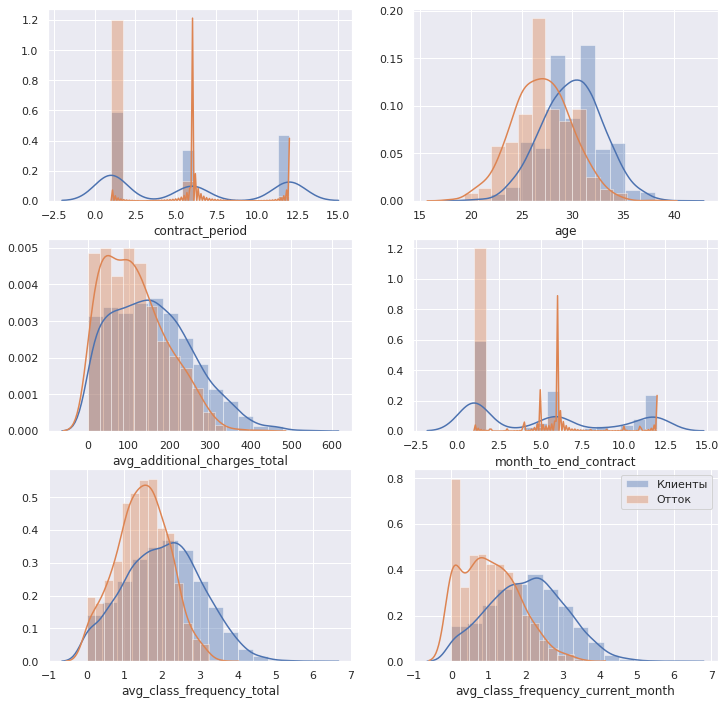

In [48]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, number_c):
    sns.distplot(df.query('churn==0')[col], bins=15,ax=ax, label ='Клиенты')
    sns.distplot(df.query('churn==1')[col], bins=15,ax=ax, label ='Отток')
    ax.set(xlabel=col)
plt.legend(loc='upper right', bbox_to_anchor=(1., 1.))
plt.show()

In [49]:
# дополнительно посмотрим на month_to_end_contract
month_to_end = (df.reset_index()
                .pivot_table(index = 'month_to_end_contract', columns = 'churn', values = 'index', aggfunc = 'nunique'))
month_to_end.T

month_to_end_contract,1,2,3,4,5,6,7,8,9,10,11,12
churn,,,,,,,,,,,,
0,1273,12,22,51,111,569,24,37,72,80,177,511
1,934,2,1,7,19,76,1,1,1,2,4,13


In [50]:
# дополнительно посмотрим на contract_period
contract = (df.reset_index()
                .pivot_table(index = 'contract_period', columns = 'churn', values = 'index', aggfunc = 'nunique'))
contract.T

contract_period,1,6,12
churn,,,
0,1273,729,937
1,934,104,23


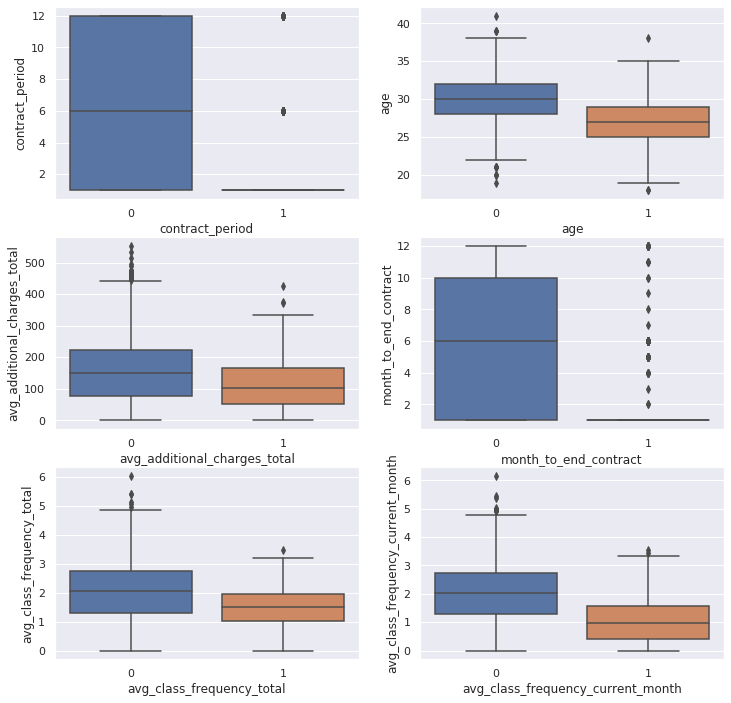

In [51]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, number_c):
    sns.boxplot(x = 'churn', y = col, data=df,ax=ax)
    ax.set(xlabel=col)
plt.show()

На графиках видно, что для ушедших клиентов характерно следующее:
- меньшее количество посещений занятий в среднем и еще более заметная разница для текущего месяца;
- меньшее количество трат на дополнительные услуги фитнес-центра;
- в среднем меньший срок контракта - на графиках это не очень ясно, а на таблицах очевидно. Абсолютное большинство ушедших клиентов брали абонемент на месяц, этому же соответствует количество месяцев до окончания контракта.
- меньший возраст - средний возраст ушедшего клиента меньше, чем средний возраст оставшегося, на три года.

Графики с распределением boxplot подтверждают те же наблюдения.

Построим матрицу корреляций.

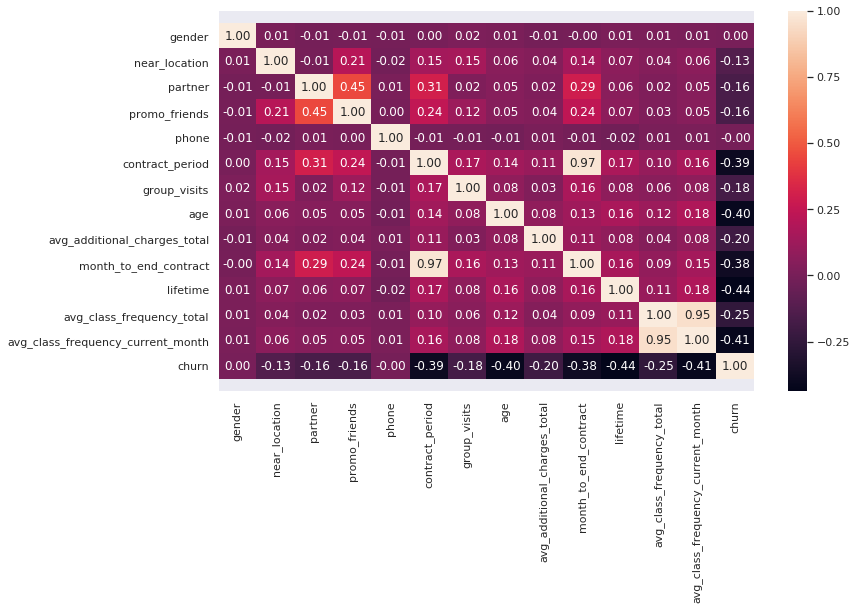

In [52]:
corr = df.corr()
f, ax = plt.subplots(figsize = (12,7))
ax = sns.heatmap(corr, xticklabels = corr.columns, fmt='.2f', 
                 yticklabels = corr.columns, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Матрица корреляций подтверждает картину на графиках: больше всего на отток пользователей влияет длительность контракта, возраст и посещение групповых занятий.

##  3. Модель прогнозирования оттока пользователей <a name="3"></a>

В проекте не требуется выведения результатов прогноза и стандартизации данных, поэтому в этом разделе сравним эффективность двух моделей на данных - логистической регрессии и случайного леса.

In [53]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.2)

In [54]:
# функция для выведения метрик
def print_all_metrics(y_test, y_pred, title):
    print(title)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_test, y_pred)))

In [55]:
# модель логистической регрессии

lr_model = LogisticRegression(max_iter = 5000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print_all_metrics(y_test, y_pred_lr, title = 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.934
	Precision: 0.906
	Recall: 0.843


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [56]:
# перебор параметров max_depth и n_estimators для модели случайного леса

test_results = pd.DataFrame(columns=['depth', 'estimators', 'accuracy', 'precision', 'recall'])
rows_list = []

for depth in range(2, 19, 2):
    for estim in range(10, 101, 10):
        model = RandomForestClassifier(random_state=1, n_estimators=estim, max_depth=depth)
        model.fit(X_train, y_train)

        test_pred = model.predict(X_test)
        
        rows_list.append({
            'depth': depth,
            'estimators': estim,
            'accuracy': accuracy_score(y_test, test_pred),
            'precision': precision_score(y_test, test_pred),
            'recall': recall_score(y_test, test_pred)
        })

test_results = pd.DataFrame(rows_list)

test_results.sort_values(by=['accuracy', 'precision', 'recall'], ascending=False).head(10)

,depth,estimators,accuracy,precision,recall
61,14,20,0.93375,0.905941,0.843318
66,14,70,0.93250,0.893720,0.852535
67,14,80,0.93250,0.893720,0.852535
63,14,40,0.93000,0.892683,0.843318
69,14,100,0.92875,0.892157,0.838710
68,14,90,0.92875,0.884615,0.847926
75,16,60,0.92875,0.880952,0.852535
62,14,30,0.92750,0.891626,0.834101
70,16,10,0.92750,0.891626,0.834101
71,16,20,0.92750,0.891626,0.834101


Лучшие результаты - для max_depth = 14  и n_estimators = 20, используем их.

In [57]:
# модель случайного леса

rf_model = RandomForestClassifier(n_estimators = 20, random_state = 1, max_depth = 14)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print_all_metrics(y_test, y_pred_rf, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.934
	Precision: 0.906
	Recall: 0.843


При переборе параметров обе модели дают одинаковый результат.

##  4. Кластеризация пользователей <a name="4"></a>

In [60]:
# стандартизируем данные
sc = StandardScaler()
x_sc_4 = sc.fit_transform(df.drop(columns = ['churn']))

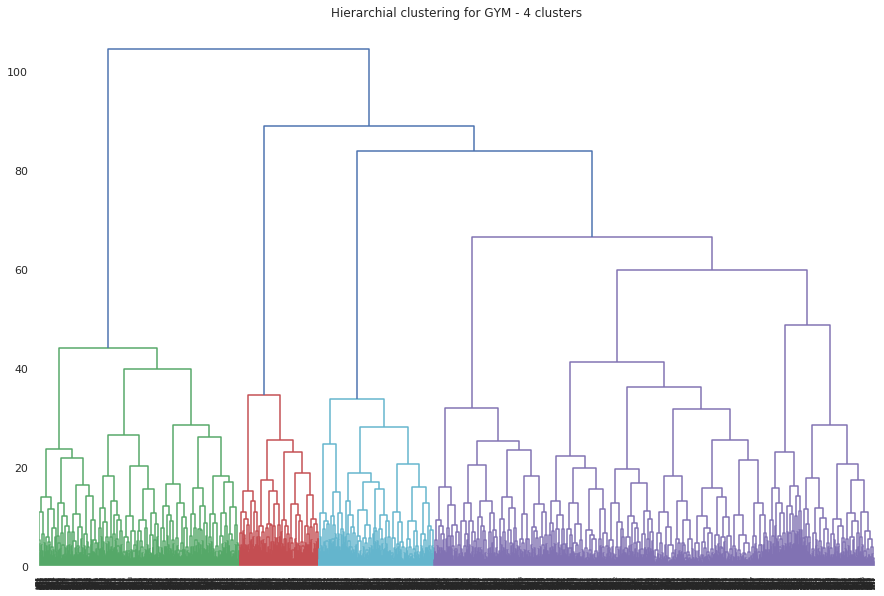

In [61]:
linked = linkage(x_sc_4, method = 'ward')
# график кластеризации
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM - 4 clusters')
plt.show()

In [62]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 1)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc_4)

In [63]:
df['cluster'] = labels
# средние значения по кластерам
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.500960,0.519319,0.498371,0.505426,0.523316
near_location,0.000000,1.000000,0.951140,1.000000,0.862694
partner,0.464491,0.224623,0.739414,0.773643,0.471503
promo_friends,0.078695,0.000000,0.466884,1.000000,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,2.343570,2.056974,11.511401,2.972093,4.777202
group_visits,0.216891,0.379175,0.543974,0.451163,0.427461
age,28.579655,28.918140,29.964169,29.120930,29.297927
avg_additional_charges_total,136.561586,141.863877,166.325823,141.317434,144.208179
month_to_end_contract,2.197697,1.963982,10.457112,2.778295,4.466321


In [64]:
# доля клиентов в каждом кластере
df['cluster'].value_counts(normalize = True)

1    0.38175
2    0.23025
3    0.16125
0    0.13025
4    0.09650
Name: cluster, dtype: float64

Очевидные сразу выводы:
- кластер 3 - клиенты, для которых отток характерен с наименьшей вероятностью;
- кластеры 0 и 1 - наибольшая вероятность оттока;
- кластеры 2 и 4 - вероятность оттока такая же, какая для всего датасета.

При этом в последний, 4 кластер попало меньше всего клиентов - это почему-то люди без указанного номера телефона.

**Кластер 3:**
- клиенты с самой большой длительностью контракта,
- с высокой вероятностью пользующиеся партнерской программой или приглашениями друзей,
- самые большие траты на дополнительные услуги фитнес-центра,
- самая большая вероятность посещения групповых занятий,
- самая высокая посещаемость, которая не падает за последний месяц,
- обязательно живут или работают возле фитнес-центра.

**Кластеры 2 и 4:**
- меньший срок контракта и меньшее количество посещений групповых занятий, чем в кластере 3;
- приблизительно тот же средний возраст, что в кластере 3,
- для них характерна меньшая частота посещений (менее 2), которая падает за последний месяц;
- при этом уровень пользования партнерскими программами и приглашениями друзей в кластере 2 самый высокий для всего датасета, вероятно, поэтому отток в нем чуть ниже, чем в кластере 4 - в частности, весь кластер 2 пользовался приглашениями друзей;
- длительность контракта в кластере 4 выше, чем в 2.

**Кластеры 1 и 0:**
- клиенты с самой большой вероятностью оттока,
- самая низкая продолжительность контракта;
- самое низкое среднее количество посещений групповых занятий (но для кластера 1 оно почти такое же, как в 2 и 4);
- самая значительная разница между посещением в среднем и посещением за последний месяц - второе значительно ниже,
- для кластера 0 характерен  самый низкий среди всех кластеров средний возраст;
- при этом пользование партнерскими программами и приглашениями друзей для кластера 0 все же выше, чем для 1, хотя оба эти значения самые низкие в датасете;
- в кластер 0 попали только те, кто не живет/работает возле фитнес-центра.

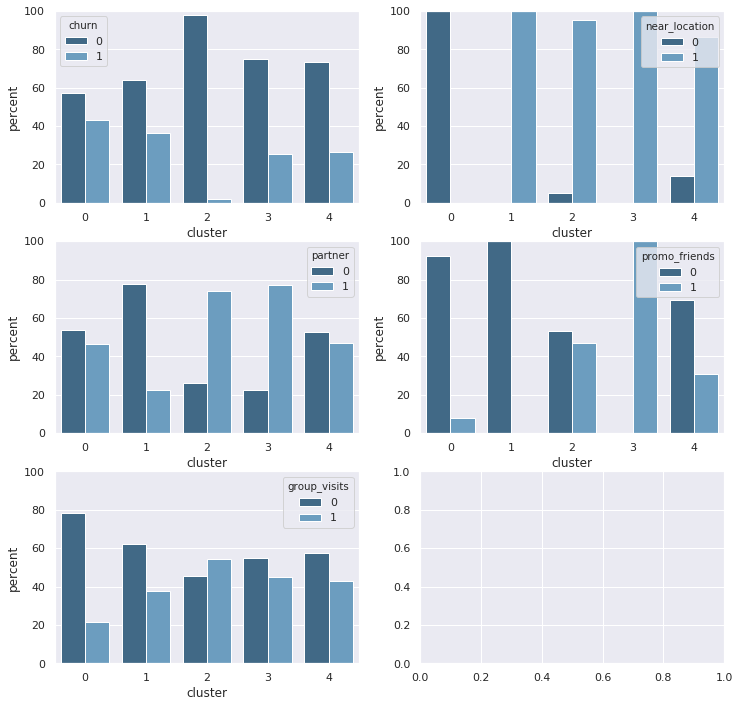

In [65]:
cluster_c = ['churn', 'near_location', 'partner', 'promo_friends', 'group_visits']

f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, cluster_c):
    percent = (df.groupby('cluster')[col]
                     .value_counts(normalize=True).mul(100)
                     .rename('percent').reset_index())
    sns.catplot(x='cluster', y='percent', hue=col,kind='bar',
              data=percent, palette="Blues_d", ax=ax)
    ax.set(ylim = (0,100))
    plt.close(2)
plt.show()

Графики подтверждают сделанные ранее выводы, показывая соотношения без учета численности клиентов в кластерах:
- в частности, отчетливо выделяется максимальный отток для кластера 0, меньший для 1, 2 и 4, и минимальный для 3;
- никто из кластера 0 не живет/работает около фитнес-клуба;
- самый большой процент пользования партнерскими соглашениями - у кластеров 2 и 3,
- весь кластер 2 и половина кластера 3 попала в фитнес-клуб по приглашению друзей, и напротив, никто из кластера 1 и почти весь кластер 0 таким приглашением не пользуется,
- кластер 0 с наименьшей вероятностью посещает групповые занятия, а кластер 3 - с наибольшей.

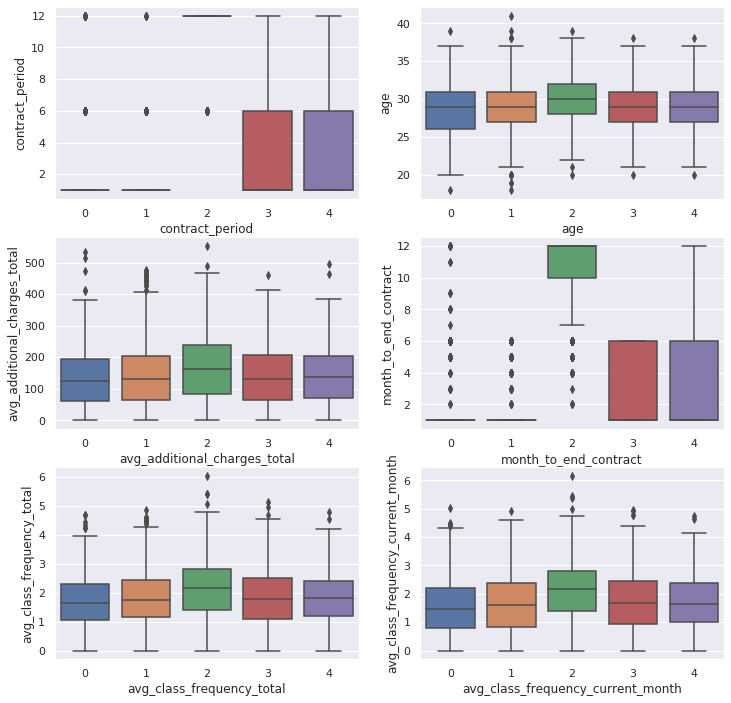

In [66]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, number_c):
    sns.boxplot(x = 'cluster', y = col, data=df,ax=ax)
    ax.set(xlabel=col)
plt.show()

Распределения также подтверждают сделанные ранее выводы:
- видны максимальная длина контракта для кластера 3 и вторая по длительности - для кластеров 2 и 4 (это также видно по количеству месяцев до окончания контракта), 
- максимальный средний возраст для кластера 3 и минимальный - для 0,
- самые высокие дополнительные траты для кластера 3;
- самая высокая посещаемость для кластера 3;
- самая низкая посещаемость для кластеров 0 и 1, которая проседает в текущем месяце относительно предыдущих.

##  5. Выводы и рекомендации <a name="5"></a>

Как мы видим на протяжении всего анализа, самые важные причины, влияющие на отток пользователей, следующие:

- меньший возраст,
- проживание/работа далеко от фитнес-центра,
- маленькая продолжительность контракта,
- низкий уровень востребованности партнерских программ и акций "приведи друга" среди уходящих клиентов.

Важная черта, характерная для уходящих пользователей: сначала снижается количество посещений, потом они уходят; хотя именно для этого утверждения хорошо бы иметь больше данных с посещениями за каждый месяц, потому что мы можем иметь дело не с реальным снижением посещаемости, а с тем, что пользователи уже не ходят или ходили только в начале месяца и все равно попали в датасет.

При этом для клиентов, которые ходят долго, характерна обратная ситуация: проживание или работа возле фитнес-центра, активное пользование программами лояльности, более высокие траты на дополнительные услуги и более старший средний возраст.
Отсюда делаем выводы для стратегии взаимодействия с клиентами.

1. Необходимо более активное продвижение программ лояльности и акций - они очевидно работают, и клиенты, пользующиеся ими, ходят дольше;
2. Нужно предлагать абонементы более длительного срока со скидками или вместе с какими-то дополнительными опциями, чтобы сделать их более привлекательными для вновь приходящих клиентов; 
3. Нужно обратить отдельное внимание на клиентов младше и старше (в фитнес-клубе почти нет клиентов старше 40), чем средняя аудитория, и сделать какие-то специальные акции и предложения для них;
4. Выделять клиентов, частота посещения которых начинает падать, и делать им персональные предложения/скидки, чтобы повысить их интерес и удержать в клубе.